# Comparison of popular Polynomial Chaos expansion implementations in Python

In this notebook, we compare the `sklearn` implementation of Polynomial
Chaos expansions (PCEs) to the implementation in `chaospy` and `pygpc` (the first two hit in a Google search for `python polynomial chaos`).

As a test case, we will use the well-known Sobol function, defined as

$$y = \prod_{j=1}^d \frac{|4x_j - 2| + a_j}{1 + a_j}$$

where the inputs $x_j$ follow a standard uniform distribution, and the
coefficients $a_j, j=1, 2, \ldots, d$ are all nonzero. We choose $d = 8$ and the
values

| $j$ | $a_j$ |
|---|-----|
| 1 | 1 |
| 2 | 2 |
| 3 | 5 |
| 4 | 10 |
| 5 | 20 |
| 6 | 50 |
| 7 | 100 |
| 8 | 500 |

The values of the Sobol sensitivity indices can be computed analytically. In
particular, let

$$ D = \prod_{j=1}^d (D_j + 1) - 1$$

with

$$ D_j = \frac{1}{3(1 + a_j)^2} $$

then the value of the $j$ th main-effect index is $D_j / D$. We investigate the
accuracy and cost of computing the main-effect Sobol sensitivity indices from a
PCE with increasing degree, for `chaospy`, `pygpc` and `sklearn`.

In [1]:
# import statements
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle as pk

In [2]:
# qualified imports
from matplotlib.ticker import MaxNLocator
from numpy.linalg import norm

In [3]:
# first, let's define the parameters in the model
a = np.array([1, 2, 5, 10, 20, 50, 100, 500])

In [4]:
# compute the exact values of the sensitivity indices
def exact(d):
    D_j = 1 / (3*(1 + a[:d])**2)
    D = np.prod(D_j + 1) - 1
    return D_j / D

In [5]:
# gather all main sensitivity indices
main_sens = dict()
for file in os.listdir("timings"):
    if file.startswith("main_sens"):
        with open(os.path.join("timings", file), "rb") as f:
            sens = pk.load(f)
        d = int(file.split("_")[2][1:])
        k = int(file.split("_")[3][1:])
        m = file.split("_")[-1]
        if not m in main_sens:
            main_sens[m] = dict()
        if not d in main_sens[m]:
            main_sens[m][d] = dict()
        main_sens[m][d][k] = sens

In [6]:
# check difference between main sensitvitiy indices computed by sklearn and chaospy
for d in [2, 4, 8]:
    ms = dict()
    for key, val in main_sens.items():
        if d in val:
            k = sorted(val[d].keys())
            m = [val[d][j] for j in k]
            ms[key] = np.vstack(m)
    # shape = min(m.shape for m in ms.values())
    for method in main_sens.keys():
        # print(ms[method])
        # print(exact(d))
        error = norm(ms[method] - exact(d))
        print(f"dimension {d} | {method} error: {error}")
    
    # m_chaospy = ms["chaospy"][:shape[0], :shape[1]]
    # m_pygpc = ms["pygpc"][:shape[0], :shape[1]]

    # error = np.linalg.norm(m_sklearn - m_chaospy) / np.linalg.norm(m_sklearn)
    # print(f"dimension {d} | difference between sklearn and chaospy indices: {error}")
    # m_pygpc = ms["pygpc"][:shape[0], :shape[1]]
    # error = np.linalg.norm(m_sklearn - m_pygpc)
    # print(f"dimension {d} | difference between sklearn and pygpc indices: {error}")

dimension 2 | sklearn error: 1.1813392208587747
dimension 2 | pygpc error: 0.5397875806874866
dimension 2 | chaospy error: 1.1813392269980159
dimension 4 | sklearn error: 0.07129421456943032
dimension 4 | pygpc error: 0.0603924625026193
dimension 4 | chaospy error: 0.07129421457084667
dimension 8 | sklearn error: 0.0634170933937357
dimension 8 | pygpc error: 0.07143656236548258
dimension 8 | chaospy error: 0.06341372703314718


In [7]:
# gather all timings
duration = dict()
for file in os.listdir("timings"):
    if file.startswith("duration"):
        with open(os.path.join("timings", file), "rb") as f:
            time = pk.load(f)
        d = int(file.split("_")[1][1:])
        k = int(file.split("_")[2][1:])
        m = file.split("_")[-1]
        if not m in duration:
            duration[m] = dict()
        if not d in duration[m]:
            duration[m][d] = dict()
        duration[m][d][k] = time

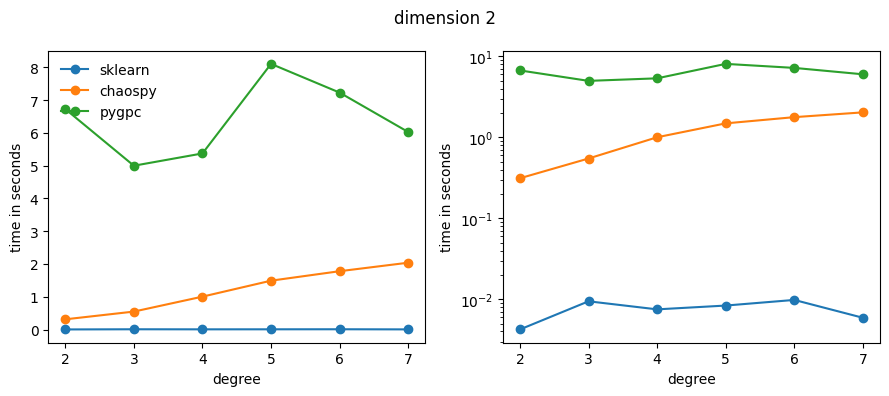

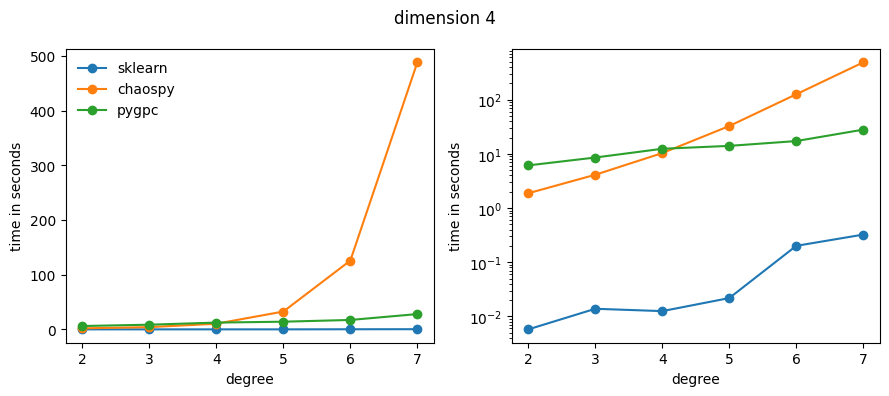

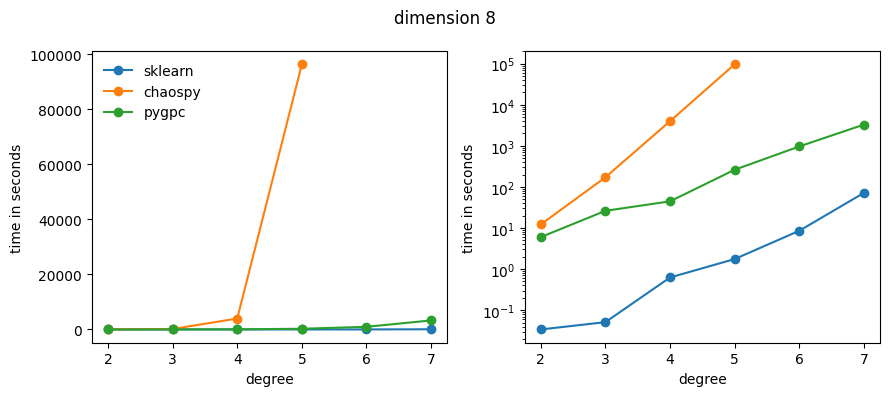

In [8]:
# plot timings
for d in [2, 4, 8]:
    _, axes = plt.subplots(1, 2, figsize=(9, 4))
    for ax in axes:
        for key, val in duration.items():
            if d in val:
                k = sorted(val[d].keys())
                t = [val[d][j] for j in k]
                ax.plot(k, t, marker="o", label=key)
        ax.set_xlabel("degree")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylabel("time in seconds")
    plt.suptitle(f"dimension {d}")
    axes[0].legend(frameon=False, loc="upper left")
    axes[1].set_yscale("log")
    plt.tight_layout()